<a href="https://colab.research.google.com/github/silaamohammedyousri-web/medical-image-Task3/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train size: 4708
Test size: 624


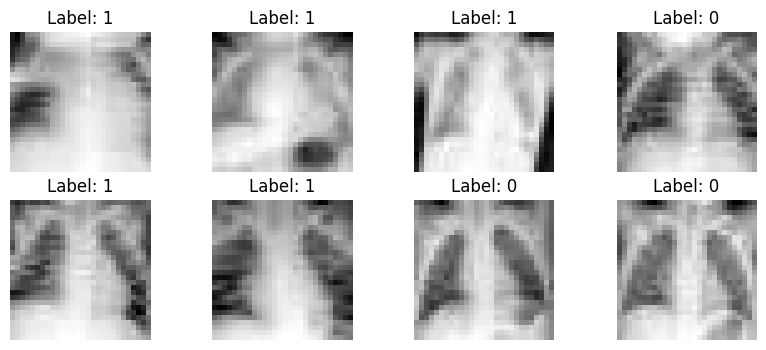

Using device: cpu
Epoch [1/20], Loss: 0.5936, Accuracy: 74.21%
Epoch [2/20], Loss: 0.5682, Accuracy: 74.21%
Epoch [3/20], Loss: 0.5652, Accuracy: 74.21%
Epoch [4/20], Loss: 0.5624, Accuracy: 74.21%
Epoch [5/20], Loss: 0.5591, Accuracy: 74.21%
Epoch [6/20], Loss: 0.5544, Accuracy: 74.21%
Epoch [7/20], Loss: 0.5485, Accuracy: 74.21%
Epoch [8/20], Loss: 0.5386, Accuracy: 74.21%
Epoch [9/20], Loss: 0.5250, Accuracy: 74.21%
Epoch [10/20], Loss: 0.5021, Accuracy: 74.21%
Epoch [11/20], Loss: 0.4661, Accuracy: 75.02%
Epoch [12/20], Loss: 0.4080, Accuracy: 80.65%
Epoch [13/20], Loss: 0.3312, Accuracy: 86.17%
Epoch [14/20], Loss: 0.2760, Accuracy: 89.15%
Epoch [15/20], Loss: 0.2396, Accuracy: 90.61%
Epoch [16/20], Loss: 0.2223, Accuracy: 91.29%
Epoch [17/20], Loss: 0.2089, Accuracy: 91.78%
Epoch [18/20], Loss: 0.2011, Accuracy: 91.78%
Epoch [19/20], Loss: 0.1954, Accuracy: 91.86%
Epoch [20/20], Loss: 0.1808, Accuracy: 92.37%


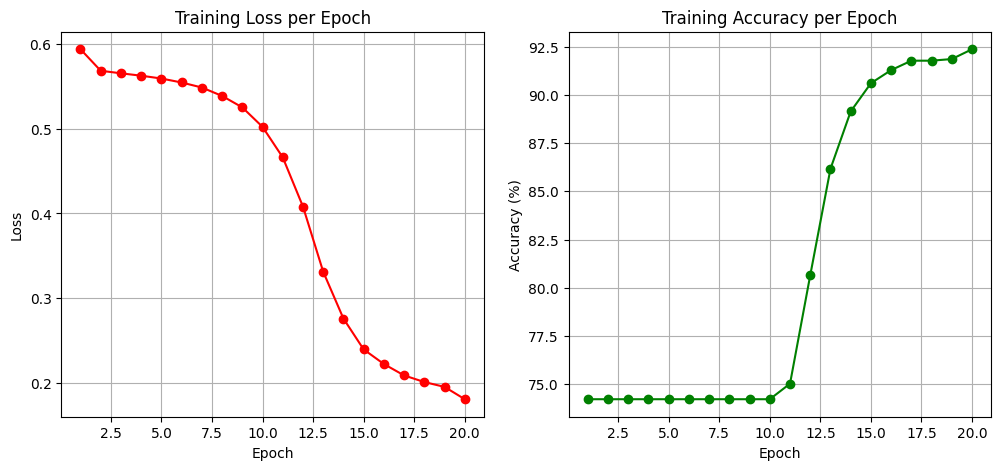


Test Accuracy: 87.34%



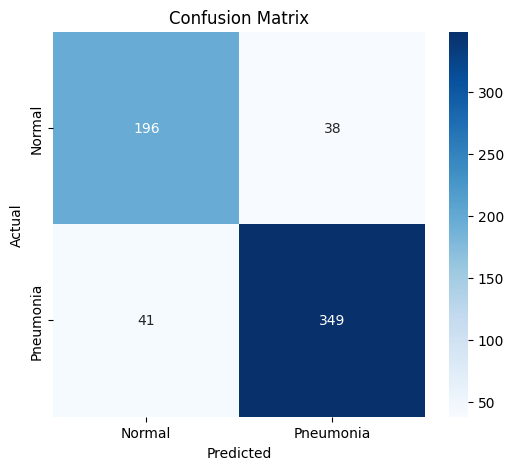

Classification Report:

              precision    recall  f1-score   support

      Normal       0.83      0.84      0.83       234
   Pneumonia       0.90      0.89      0.90       390

    accuracy                           0.87       624
   macro avg       0.86      0.87      0.87       624
weighted avg       0.87      0.87      0.87       624



In [2]:
!pip install medmnist

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import medmnist
from medmnist import PneumoniaMNIST
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

data_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = PneumoniaMNIST(split='train', transform=data_transform, download=True)
test_dataset  = PneumoniaMNIST(split='test', transform=data_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

images, labels = next(iter(train_loader))
plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.fc1 = nn.Linear(32*7*7, 64)
        self.fc2 = nn.Linear(64,2)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2)
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 20
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze().long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,num_epochs+1), train_losses, marker='o', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1,num_epochs+1), train_accuracies, marker='o', color='green')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()


model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze().long()
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Test Accuracy
accuracy = (all_preds == all_labels).mean() * 100
print(f"\nTest Accuracy: {accuracy:.2f}%\n")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal','Pneumonia'],
            yticklabels=['Normal','Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=['Normal','Pneumonia']))
